Code for the completion of exercises 1.

In [2]:
# Time values extracted from the given data
import numpy as np



In [10]:
# Function to find the closest time index for some given time value
def find_closest_time_index(time_values: list[float], target_time: float) -> int:
    low, high = 0, len(time_values) - 1
    while low < high:
        mid = (low + high) // 2
        if time_values[mid] < target_time:
            low = mid + 1
        else:
            high = mid
    return low if abs(time_values[low] - target_time) < abs(time_values[low - 1] - target_time) else low - 1

# A
The first section asks for a iterative scheme to integrate the steady state solution as described in the notes. The differential that we aim to find a solution for is

$$\beta b^3\partial_{z}b = \alpha b^3 - Q$$

for some constant Q and b a function of z only (steady state solution).

In [4]:
# A discretization update scheme allowing for the interation from b0 = 0 to bJ = H
def iterative_scheme(alpha, beta, Q, bPrev, H, dz):
    # We calculate the forward euler discretization approximation of the derivative
    b = bPrev + dz * (alpha * bPrev**3 - Q) / (beta * bPrev**3)
    return b

def solve(alpha, beta, Q, H, J, b0) -> list[tuple[float, float]]:
    # Initialize the array to store the values of b at each step
    b_values = [b0]
    dz = H / J

    # Iteratively apply the update scheme to compute b at each step
    for j in range(1, J + 1):
        b_next = iterative_scheme(alpha, beta, Q, b_values[-1], H, dz)
        b_values.append(b_next)

    # Create a 2 column table of z againsst b values 
    z_values = [j * dz for j in range(J + 1)]
    result: list[tuple[float, float]] = list(zip(z_values, b_values))
    
    return result

In [5]:
result = solve(0.4709, 1, 0.99, 1, 1000, 1.178164343)

# Move result into pandas dataframe
import pandas as pd
df = pd.DataFrame(result, columns=['z', 'b'])



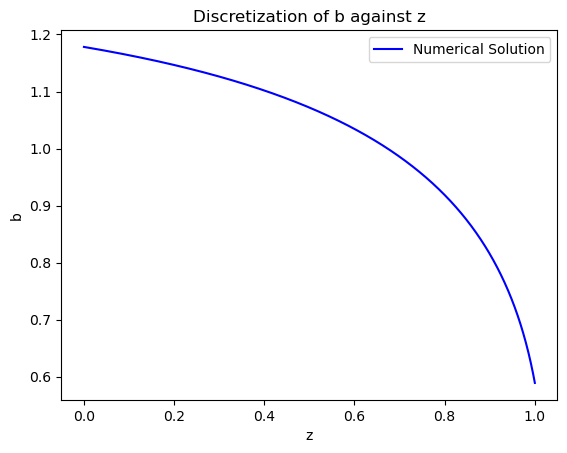

In [6]:
# Plot the results with plotly.express
# import plotly.express as px

# fig = px.line(df, x='z', y='b', title='Discretization of b against z', labels={'z': 'z', 'b': 'b'})
# fig.show()

# Plot steady state solution with matplotlib
import matplotlib.pyplot as plt
plt.plot(df['z'], df['b'], label='Numerical Solution', color='blue')
plt.xlabel('z')
plt.ylabel('b')
plt.title('Discretization of b against z')
plt.legend()
plt.show()



In [7]:
df

,z,b
0,0.000,1.178164
1,0.001,1.178030
2,0.002,1.177895
3,0.003,1.177760
4,0.004,1.177625
...,...,...
996,0.996,0.605585
997,0.997,0.601598
998,0.998,0.597522
999,0.999,0.593352


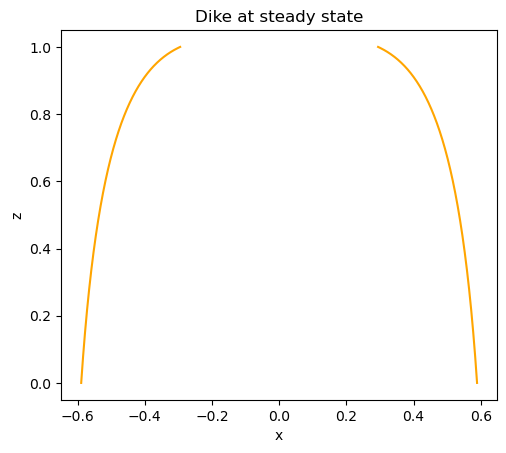

In [8]:
# A plot of the dike at steady state throughout its height z and with width b
# A plot with two lines that are symmetric about the y-axis with the x-axis being b/2 and the y-axis being z
table = {
    "z": [row[0] for row in result], 
    "b": [row[1] for row in result], 
    "b/2": [row[1]/2 for row in result], 
    "-b/2": [-row[1]/2 for row in result]
}
# Use matplotlib to plot with lines for b/2 and -b/2 against z
import matplotlib.pyplot as plt
plt.plot(table["b/2"], table["z"], label='b/2', color='orange')
plt.plot(table["-b/2"], table["z"], label='-b/2', color='orange')
plt.xlabel('x')
plt.ylabel('z')
plt.title('Dike at steady state')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


# B
Plotting for the time-dependent solution

In [9]:
# Solving for the time dependent solution

# One iteration of the time dependent scheme
def time_d_iteration(bPrev: list[float], alpha: float, b0: float, 
                     beta: float, dz: float, dt: float):
    # Note that bPrev is the points from the previous time step at j-1, j and j+1 where we are 
    # calculating for the current time step at position j
    bNext: float = bPrev[1] - dt * (3 * alpha * b0 ** 2 * (bPrev[1] - bPrev[0]) / dz 
                             - beta * b0 ** 3 * (bPrev[2] - 2 * bPrev[1] + bPrev[0]) / dz**2)
    return bNext

def solve_time_dependent(alpha: float, beta: float, H: float, 
                         b0: float, bT: float, J: int, dt: float, max_time: float = 2.5):
    # Solving the time dependent problem considering perturbations from a constant start
    # value bT at t = 0 with boundary conditions b(0, t) = b0 and b(H, t) = bT.
    # Note the possibility of discontinuity at z = 0 at t = 0.

    # Initialize arrays
    dz: float = H / J
    print(f'dz: {dz}')

    # Calculate the upper bound on dt for stability
    dt_stable: float = dz**2 / (3 * dz * alpha * b0**2 + 2 * beta * b0 ** 3)
    print(f"Stable dt: {dt_stable}, Given dt: {dt}")

    z_values: list[float] = [j * dz for j in range(J + 1)]
    b_values: list[list[float]] = [[0 for _ in range(J + 1)]]  # Initial condition: b(z, 0) = b0 for all z, t in the first index, z in the second index

    time_steps = int(max_time / dt)
    print(f'Time steps: {time_steps}')
    for time_step in range(time_steps):
        # Initialize the next time step array with boundary condition
        b_next: list[float] = [b0 - bT] + [0.0 for _ in range(1, J)] + [0]
        for j in range(1, J):
            b_next[j] = time_d_iteration(b_values[-1][j-1:j+2], alpha, b0, beta, dz, dt)
        b_values.append(b_next)

    time_values: list[float] = [n * dt for n in range(len(b_values))]

    # Adjust all the b_values back up by bT
    for n in range(len(b_values)):
        for j in range(len(b_values[n])):
            b_values[n][j] += bT
        
    return z_values, time_values, b_values


In [10]:
z_values, time_values, b_values = solve_time_dependent(0.4709, 1, 1, 1.178164343, 0.585373798, 41, 1e-4)


# Store the time values as an array
t = np.array([0.05, 0.1, 0.2, 0.5, 1, 2])

dz: 0.024390243902439025
Stable dt: 0.0001792586221928934, Given dt: 0.0001
Time steps: 25000


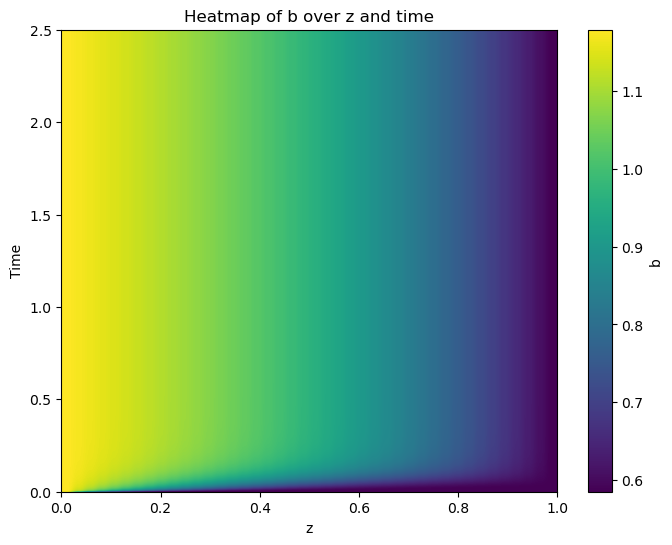

In [11]:
import numpy as np

import matplotlib.pyplot as plt

# Convert b_values to a 2D numpy array (time x z)
arr = np.array(b_values)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(
    arr,
    aspect='auto',
    origin='lower',  # so time increases upward like in the Plotly version
    extent=(z_values[0], z_values[-1], time_values[0], time_values[-1]),
    cmap='viridis'
)

ax.set_xlabel('z')
ax.set_ylabel('Time')
ax.set_title('Heatmap of b over z and time')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('b')

plt.show()



In [12]:
# Plot for grid sizes 5, 11, 21, 41

# 5
z_values_5, time_values_5, b_values_5 = solve_time_dependent(0.4709,
                                                              1, 1, 1.178164343, 0.585373798, 5, 1e-4)

# 11
z_values_11, time_values_11, b_values_11 = solve_time_dependent(0.4709, 
                                                                1, 1, 1.178164343, 0.585373798, 11, 1e-4)

# 21
z_values_21, time_values_21, b_values_21 = solve_time_dependent(0.4709, 
                                                                1, 1, 1.178164343, 0.585373798, 21, 1e-4)

# 41
z_values_41, time_values_41, b_values_41 = solve_time_dependent(0.4709, 
                                                               1, 1, 1.178164343, 0.585373798, 41, 1e-4)

dz: 0.2
Stable dt: 0.010920196727129326, Given dt: 0.0001
Time steps: 25000
dz: 0.09090909090909091
Stable dt: 0.0023961783475749702, Given dt: 0.0001
Time steps: 25000
dz: 0.047619047619047616
Stable dt: 0.0006740446977058817, Given dt: 0.0001
Time steps: 25000
dz: 0.024390243902439025
Stable dt: 0.0001792586221928934, Given dt: 0.0001
Time steps: 25000


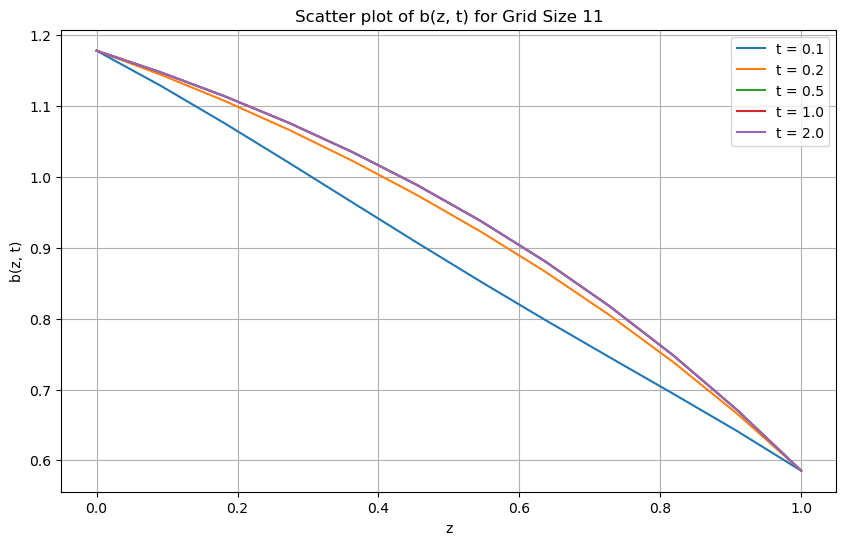

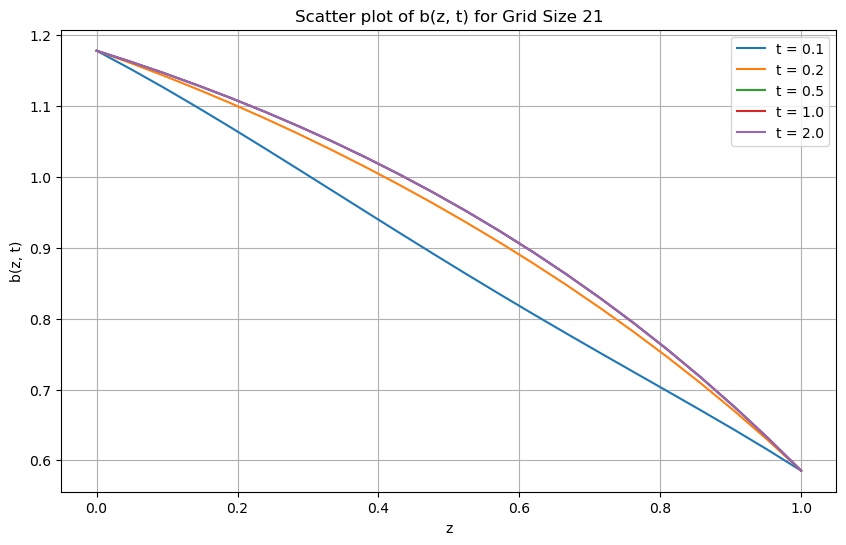

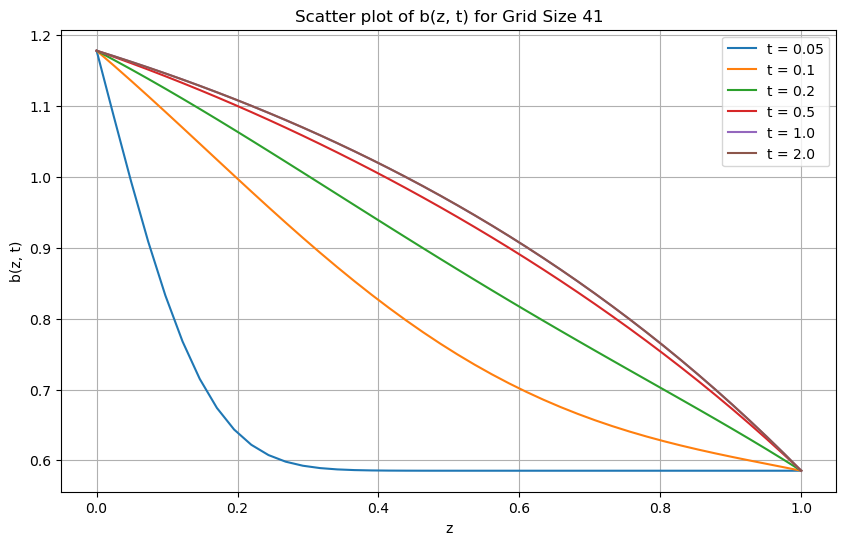

In [13]:
# Plotting for the time periods given for the different grid sizes
t = np.array([0.05, 0.1, 0.2, 0.5, 1, 2])

# Grid size 11
# Find the index of the time values closest to those in t
indices_11 = [find_closest_time_index(time_values_11, time) for time in t]

# Extract b values at this time 
b_specific_11: list[list[float]] = [b_values_11[index] for index in indices_11]

# Scatter plot for the first time period
plt.figure(figsize=(10, 6))
for i in range(1, len(t)):
    plt.plot(z_values_11, b_specific_11[i], label=f't = {t[i]}')
plt.xlabel('z')
plt.ylabel('b(z, t)')
plt.title('Scatter plot of b(z, t) for Grid Size 11')
plt.legend()
plt.grid()
plt.show()

# Grid size 21
# Find the index of the time values closest to those in t for grid size 21
indices_21 = [find_closest_time_index(time_values_21, time) for time in t]

# Extract b values at this time 
b_specific_21: list[list[float]] = [b_values_21[index] for index in indices_21]

# Plot for grid size 21
plt.figure(figsize=(10, 6))
for i in range(1, len(t)):
    plt.plot(z_values_21, b_specific_21[i], label=f't = {t[i]}')
plt.xlabel('z')
plt.ylabel('b(z, t)')
plt.title('Scatter plot of b(z, t) for Grid Size 21')
plt.legend()
plt.grid()
plt.show()

# Grid size 41
# Find the index of the time values closest to those in t for grid size 41
indices_41 = [40] + [find_closest_time_index(time_values_41, time) for time in t]

# Extract b values at this time 
b_specific_41: list[list[float]] = [b_values_41[index] for index in indices_41]

# Plot for grid size 41
plt.figure(figsize=(10, 6))
for i in range(0, len(t)):
    plt.plot(z_values_41, b_specific_41[i], label=f't = {t[i]}')
plt.xlabel('z')
plt.ylabel('b(z, t)')
plt.title('Scatter plot of b(z, t) for Grid Size 41')
plt.legend()
plt.grid()
plt.show()


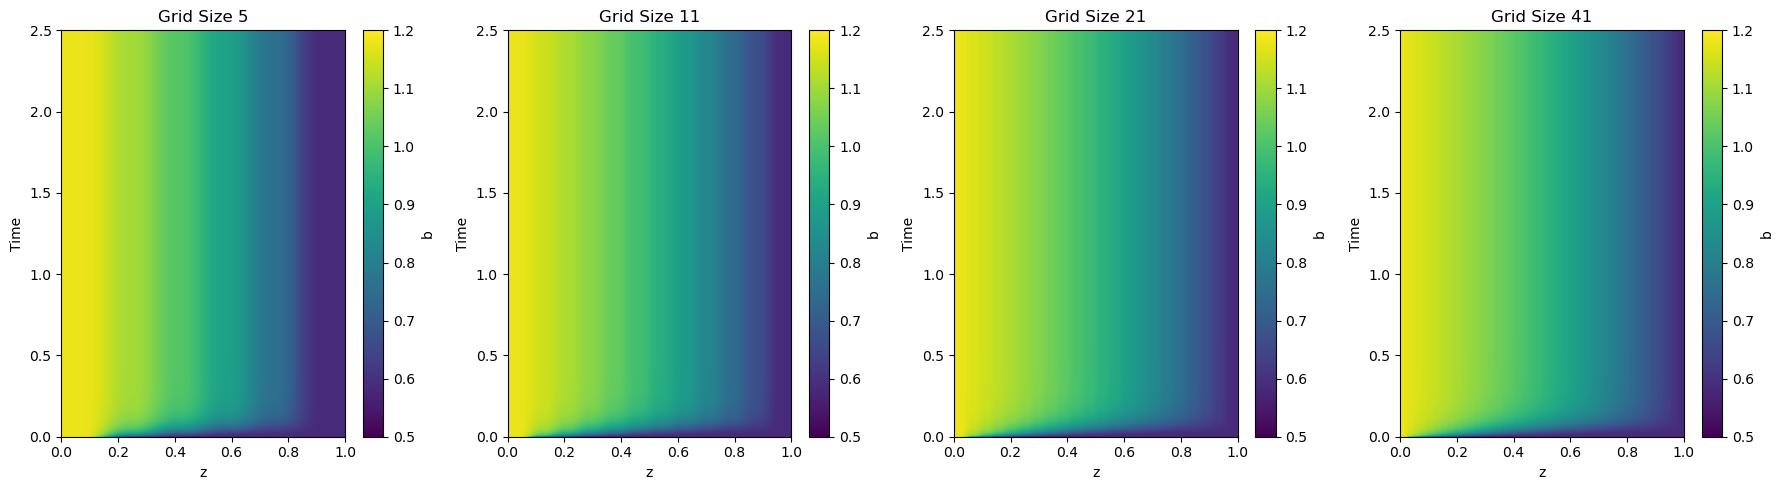

In [14]:
# Plot each of the figures with the same b value colour scale
fig, axs = plt.subplots(1, 4, figsize=(18, 5))
im1 = axs[0].imshow(
    np.array(b_values_5),
    aspect='auto',
    origin='lower',
    extent=(z_values_5[0], z_values_5[-1], time_values_5[0], time_values_5[-1]),
    cmap='viridis',
    vmin=0.5, vmax=1.2  # Set the same colour scale for all plots
)
axs[0].set_title('Grid Size 5')
axs[0].set_xlabel('z')
axs[0].set_ylabel('Time')
cbar1 = fig.colorbar(im1, ax=axs[0])
cbar1.set_label('b')

im2 = axs[1].imshow(
    np.array(b_values_11),
    aspect='auto',
    origin='lower',
    extent=(z_values_11[0], z_values_11[-1], time_values_11[0], time_values_11[-1]),
    cmap='viridis',
    vmin=0.5, vmax=1.2  # Set the same colour scale for all plots
)
axs[1].set_title('Grid Size 11')
axs[1].set_xlabel('z')
axs[1].set_ylabel('Time')

cbar2 = fig.colorbar(im2, ax=axs[1])
cbar2.set_label('b')
im3 = axs[2].imshow(
    np.array(b_values_21),
    aspect='auto',
    origin='lower',
    extent=(z_values_21[0], z_values_21[-1], time_values_21[0], time_values_21[-1]),
    cmap='viridis',
    vmin=0.5, vmax=1.2  # Set the same colour scale for all plots
)
axs[2].set_title('Grid Size 21')
axs[2].set_xlabel('z')
axs[2].set_ylabel('Time')
cbar3 = fig.colorbar(im3, ax=axs[2])
cbar3.set_label('b')

im4 = axs[3].imshow(
    np.array(b_values_41),
    aspect='auto',
    origin='lower',
    extent=(z_values_41[0], z_values_41[-1], time_values_41[0], time_values_41[-1]),
    cmap='viridis',
    vmin=0.5, vmax=1.2  # Set the same colour scale for all plots
)
axs[3].set_title('Grid Size 41')
axs[3].set_xlabel('z')
axs[3].set_ylabel('Time')
cbar4 = fig.colorbar(im4, ax=axs[3])
cbar4.set_label('b')
plt.tight_layout()
plt.show()

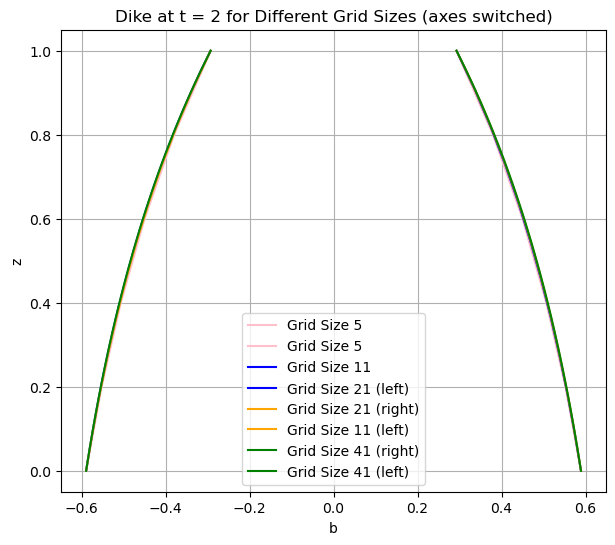

In [15]:
# Dimensional plots of the dike at t = 2 for each grid size
fig, ax = plt.subplots(figsize=(8, 6))
# switch axes: plot b/2 on x and z on y
ax.plot([b_values_5[int(2e4)][i] / 2 for i in range(len(z_values_5))], z_values_5, label='Grid Size 5', color='pink')
ax.plot([-1 * b_values_5[int(2e4)][i] / 2 for i in range(len(z_values_5))], z_values_5, label='Grid Size 5', color='pink')
ax.plot([b_values_11[int(2e4)][i] / 2 for i in range(len(z_values_11))], z_values_11, label='Grid Size 11', color='blue')
ax.plot([-1 * b_values_21[int(2e4)][i] / 2 for i in range(len(z_values_21))], z_values_21, label='Grid Size 21 (left)', color='blue')
ax.plot([b_values_21[int(2e4)][i] / 2 for i in range(len(z_values_21))], z_values_21, label='Grid Size 21 (right)', color='orange')
ax.plot([-1 * b_values_11[int(2e4)][i] / 2 for i in range(len(z_values_11))], z_values_11, label='Grid Size 11 (left)', color='orange')
ax.plot([b_values_41[int(2e4)][i] / 2 for i in range(len(z_values_41))], z_values_41, label='Grid Size 41 (right)', color='green')
ax.plot([-1 * b_values_41[int(2e4)][i] / 2 for i in range(len(z_values_41))], z_values_41, label='Grid Size 41 (left)', color='green')
ax.set_xlabel('b')
ax.set_ylabel('z')
ax.set_title('Dike at t = 2 for Different Grid Sizes (axes switched)')
ax.legend()
ax.grid()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

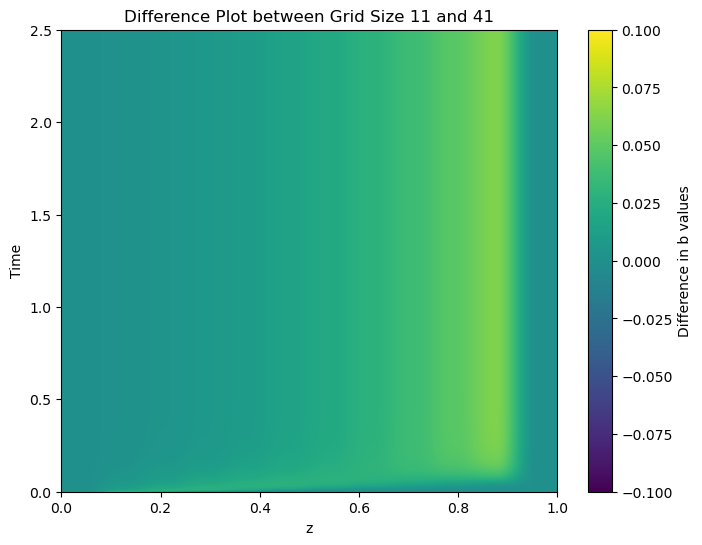

In [16]:
# Create a difference plot for 11 and 41
b_diff = np.array(b_values_11) - np.array([row[::4] + [row[-1]] for row in b_values_41] )  # Downsample 41 to match 11
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(
    b_diff,
    aspect='auto',
    origin='lower',
    extent=(z_values_11[0], z_values_11[-1], time_values_11[0], time_values_11[-1]),
    cmap='viridis',
    vmin=-0.1, vmax=0.1  # Set the colour scale for difference plot
)
ax.set_title('Difference Plot between Grid Size 11 and 41') 
ax.set_xlabel('z')
ax.set_ylabel('Time')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Difference in b values')
plt.show()

# C
Considering the error by taking the high resolution steady state solution to be exact and considering how the error in the time-dependent solutions at t=2 depends on the spacing $\Delta z$. 

In [17]:
# Take the exact solution b(z,t) from the steady state solution

b_steady: list[tuple[float, float]] = solve(0.4709, 1, 0.99, 1, 1000, 1.178164343)

index = find_closest_time_index(time_values_11, 2.0)

# Extract b values at t = 2 for each grid size 
b_5_t2 = b_values_5[index]
b_11_t2 = b_values_11[index]
b_21_t2 = b_values_21[index]
b_41_t2 = b_values_41[index]

# Extract the steady state b values at the corresponding z values for each grid size
b_steady_5 = [b_steady[int(j * 1000 / 5)][1] for j in range(6)] # Downsampling 1000 to 5
b_steady_11 = [b_steady[int(j * 1000 / 11)][1] for j in range(12)] # Downsampling 1000 to 10
b_steady_21 = [b_steady[int(j * 1000 / 21)][1] for j in range(22)] # Downsampling 1000 to 20
b_steady_41 = [b_steady[int(j * 1000 / 41)][1] for j in range(42)] # Downsampling 1000 to 40

# Check that the lengths match
assert len(b_5_t2) == len(b_steady_5)
assert len(b_11_t2) == len(b_steady_11)
assert len(b_21_t2) == len(b_steady_21)
assert len(b_41_t2) == len(b_steady_41)

# Calculate e(z,2) = b_steady(z) - b(z,2) for each grid size
e_5 = [abs(b_steady_5[j] - b_5_t2[j]) for j in range(len(b_5_t2))]
e_11 = [abs(b_steady_11[j] - b_11_t2[j]) for j in range(len(b_11_t2))]
e_21 = [abs(b_steady_21[j] - b_21_t2[j]) for j in range(len(b_21_t2))]
e_41 = [abs(b_steady_41[j] - b_41_t2[j]) for j in range(len(b_41_t2))]

In [18]:
def trapezoidal_integration(x: list[float], y: list[float]) -> float:
    integral: float = 0.0
    for i in range(1, len(x)):
        integral += 1/2 * (x[i] - x[i-1]) * (y[i] + y[i-1])
    return integral

# Calculate the integral of the squared error over the domain [0, H] for each grid size

error_5 = trapezoidal_integration(z_values_5, [e**2 for e in e_5])
error_11 = trapezoidal_integration(z_values_11, [e**2 for e in e_11])
error_21 = trapezoidal_integration(z_values_21, [e**2 for e in e_21])
error_41 = trapezoidal_integration(z_values_41, [e**2 for e in e_41])

# Calculate the L2 norm by taking the square root of the integral result
L2_5 = np.sqrt(error_5)
L2_11 = np.sqrt(error_11)
L2_21 = np.sqrt(error_21)
L2_41 = np.sqrt(error_41)

print(L2_5, L2_11, L2_21, L2_41)

0.1029659857069943 0.10327099986986517 0.10246027514922237 0.10177207686727305


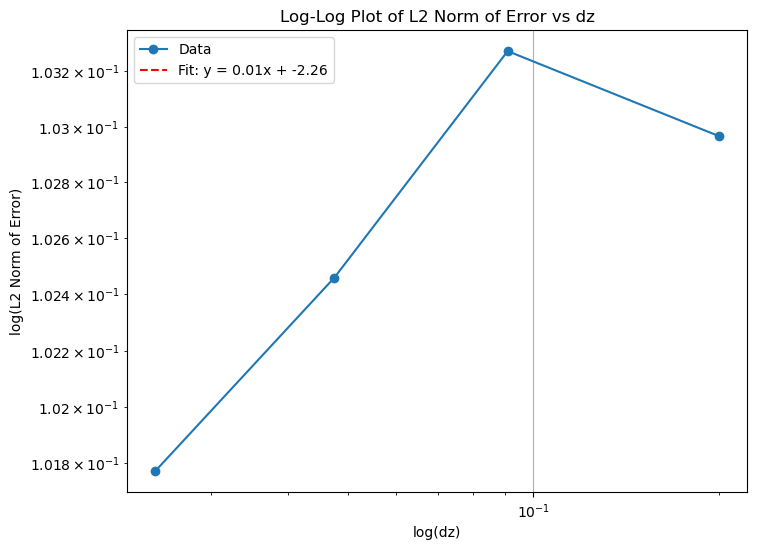

In [19]:
# Extract dz values for each grid size

dz_5 = 1 / 5
dz_11 = 1 / 11
dz_21 = 1 / 21
dz_41 = 1 / 41

# Take the log of the dz values and L2 norms
log_dz = [np.log(dz_5), np.log(dz_11), np.log(dz_21), np.log(dz_41)]
log_L2 = [np.log(L2_5), np.log(L2_11), np.log(L2_21),
            np.log(L2_41)]

# Plot log(L2) against log(dz) with a line of best fit with equation shown
plt.figure(figsize=(8, 6))
plt.plot([dz_5, dz_11, dz_21, dz_41], [L2_5, L2_11, L2_21, L2_41], marker='o')
plt.xscale("log")
plt.yscale("log")
plt.title('Log-Log Plot of L2 Norm of Error vs dz')
plt.xlabel('log(dz)')
plt.ylabel('log(L2 Norm of Error)')
plt.grid(True)

# Fit a line to the log-log data
fit = np.polyfit(log_dz, log_L2, 1)
fit_line = np.polyval(fit, log_dz)
plt.plot(log_dz, fit_line, 'r--')
plt.legend(['Data', f'Fit: y = {fit[0]:.2f}x + {fit[1]:.2f}'])

plt.show()

This would suggest an order of 0.16. !!! Must be wrong !!!

# D
Verifying that the given implicit solution gives the same result as our numerical solution

In [20]:
# Computing zr0 from the ICs
beta = 1
alpha = 0.4709
bT = 0.585373798
zr0 = -beta / alpha * (bT - np.arctanh(bT))

def residual(alpha: float, beta: float, zr0: float, b_values: list[list[float]], z_values: list[float], time_values: list[float]) -> list[list[float]]:
    # Calculating the residual error in the implicit solution when values from the numerical solution are used for b
    residuals: list[list[float]] = [[0.0 for _ in range(len(z_values))] for _ in range(len(time_values))]  # t in the first index, z in the second index
    for z in range(len(z_values)):
        for t in range(len(time_values)):
            b = b_values[t][z]
            res = z_values[z] - zr0 - alpha * time_values[t] - (beta / alpha) * (b - np.arctanh(b))
            residuals[t][z] = res
    return residuals

residuals: list[list[float]] = residual(alpha, beta, zr0, b_values_41, z_values_41, time_values_41)

# Average the absolute residuals over the domain at t = 2
# Make the 2d array into a single dimension vector
residuals_flat: list[float] = [abs(residuals[t][j]) for t in range(len(residuals)) for j in range(len(residuals[t]))]
average_residual = sum(residuals_flat) / len(residuals_flat)



/tmp/ipykernel_415339/3231670750.py:13: RuntimeWarning: invalid value encountered in arctanh
  res = z_values[z] - zr0 - alpha * time_values[t] - (beta / alpha) * (b - np.arctanh(b))


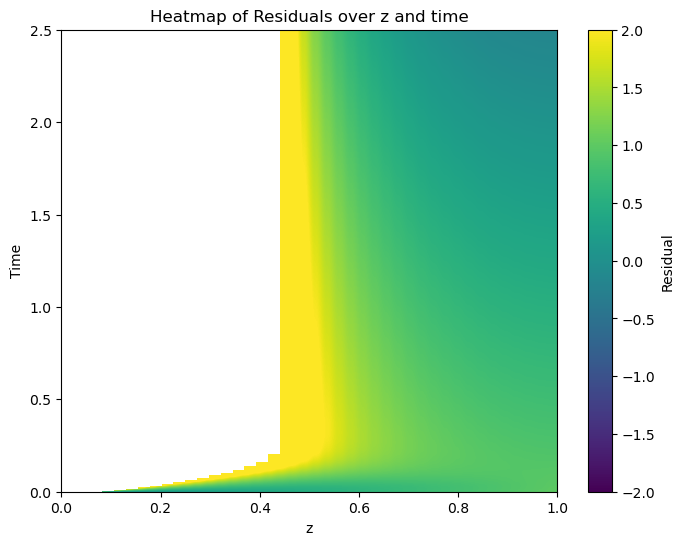

In [21]:
# Plot the residuals as a heatmap with the x-axis being z and the y-axis being time
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(
    np.array(residuals),
    aspect='auto',
    cmap='viridis',
    origin='lower',
    extent=(z_values_41[0], z_values_41[-1], time_values_41[0], time_values_41[-1]),
    vmin=-2, vmax=2  # Set the colour scale for residuals
)
ax.set_title('Heatmap of Residuals over z and time')
ax.set_xlabel('z')
ax.set_ylabel('Time')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Residual')
plt.show()




## D

In [1]:
# Define the new initial and boundary conditions based on the exact solution.
def initial_condition(z, alpha = 0.4709):
    if z > 0.3:
        return 0
    else:
        return ((3 * alpha) * (0.3 - z)) ** (1/3)
    
def bottom_boundary(t, alpha = 0.4709):
    return (3 * alpha ** 2 * (t + (0.3 / alpha))) ** (1/3)

def top_boundary(t, alpha = 0.4709):
    if t < 0.7 / alpha:
        return 0
    else:
        return (3 * alpha ** 2 * (t - (0.7 / alpha))) ** (1/3)

t=0.00: Bottom Residual=0.1766, Top Residual=0.7000
t=0.33: Bottom Residual=0.4895, Top Residual=0.5430
t=0.67: Bottom Residual=1.3334, Top Residual=0.3861
t=1.00: Bottom Residual=nan, Top Residual=0.2291
t=1.33: Bottom Residual=nan, Top Residual=0.0721
t=1.67: Bottom Residual=nan, Top Residual=0.0150
t=2.00: Bottom Residual=nan, Top Residual=0.1115
t=2.33: Bottom Residual=nan, Top Residual=0.3428
t=2.67: Bottom Residual=nan, Top Residual=0.8949
t=3.00: Bottom Residual=nan, Top Residual=nan
z=0.00, b0(z)=0.7511: Initial Residual=0.1766
z=0.10, b0(z)=0.6562: Initial Residual=0.0759
z=0.20, b0(z)=0.5208: Initial Residual=0.0203
z=0.30, b0(z)=0.0000: Initial Residual=0.0000
z=0.40, b0(z)=0.0000: Initial Residual=0.1000
z=0.50, b0(z)=0.0000: Initial Residual=0.2000
z=0.60, b0(z)=0.0000: Initial Residual=0.3000
z=0.70, b0(z)=0.0000: Initial Residual=0.4000
z=0.80, b0(z)=0.0000: Initial Residual=0.5000
z=0.90, b0(z)=0.0000: Initial Residual=0.6000
z=1.00, b0(z)=0.0000: Initial Residual=0.700

/tmp/ipykernel_660843/847844278.py:8: RuntimeWarning: invalid value encountered in arctanh
  res_bottom = -0.3 - alpha * t - (1/alpha) * (bB - np.arctanh(bB))
/tmp/ipykernel_660843/847844278.py:10: RuntimeWarning: invalid value encountered in arctanh
  res_top = 1 - 0.3 - alpha * t - (1/alpha) * (bT - np.arctanh(bT))


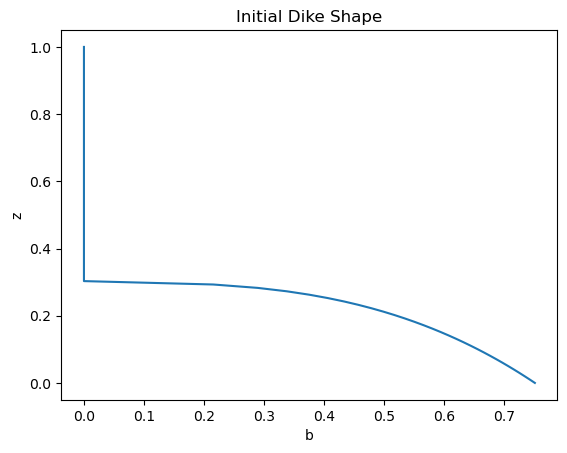

In [4]:
# Take residuals at the boundaries for some t from 0 to 3
import numpy as np
import matplotlib.pyplot as plt

alpha = 0.4709
for t in np.linspace(0, 3, 10):
    bB = bottom_boundary(t, alpha)
    res_bottom = -0.3 - alpha * t - (1/alpha) * (bB - np.arctanh(bB))
    bT = top_boundary(t, alpha)
    res_top = 1 - 0.3 - alpha * t - (1/alpha) * (bT - np.arctanh(bT))
    print(f"t={t:.2f}: Bottom Residual={res_bottom:.4f}, Top Residual={res_top:.4f}")

# Calculate the initial residuals
for z in np.linspace(0, 1, 11):
    b0 = initial_condition(z, alpha)
    res_initial = z - 0.3 - (1/alpha) * (b0 - np.arctanh(b0))
    print(f"z={z:.2f}, b0(z)={b0:.4f}: Initial Residual={res_initial:.4f}")

# Plot initial dike shape against z
z_init = np.linspace(0, 1, 100)
b_init = [initial_condition(z) for z in z_init]
plt.plot(b_init, z_init)
plt.xlabel('b')
plt.ylabel('z')
plt.title('Initial Dike Shape')
plt.show()

/tmp/ipykernel_660843/3747980019.py:7: RuntimeWarning: divide by zero encountered in arctanh
  right = (1/alpha) * (b_values[b] - np.arctanh(b_values[b]))


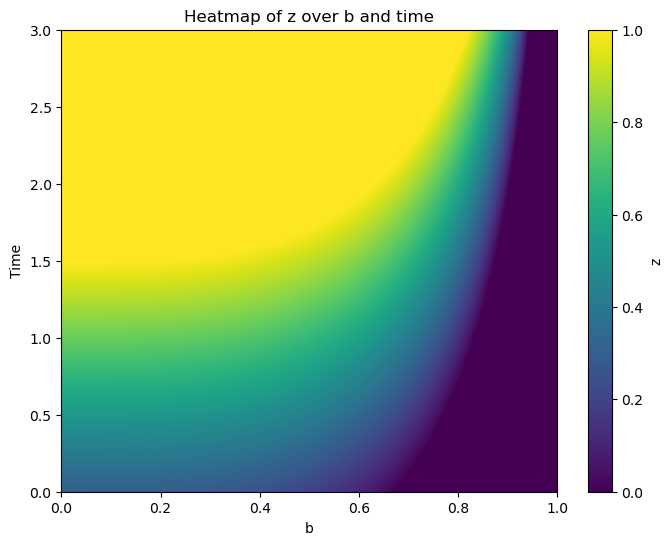

In [20]:
# Implicit calculation of z values from b and t values
t_values = np.linspace(0, 3, 1000)
b_values = np.linspace(0, 1, 1000)
z_values = np.zeros((len(t_values), len(b_values)))
for t in range(len(t_values)):
    for b in range(len(b_values)):
        right = (1/alpha) * (b_values[b] - np.arctanh(b_values[b]))
        left = 0.3 + alpha * t_values[t]
        z_values[t, b] = left + right

# Plot the z values as a heatmap with the x-axis being b and the y-axis being time
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(
    z_values,
    aspect='auto',
    cmap='viridis',
    origin='lower',
    extent=(b_values[0], b_values[-1], t_values[0], t_values[-1]),
    vmin=0, vmax=1  # Set the colour scale for z values
)
ax.set_title('Heatmap of z over b and time')
ax.set_xlabel('b')
ax.set_ylabel('Time')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('z')
plt.show()

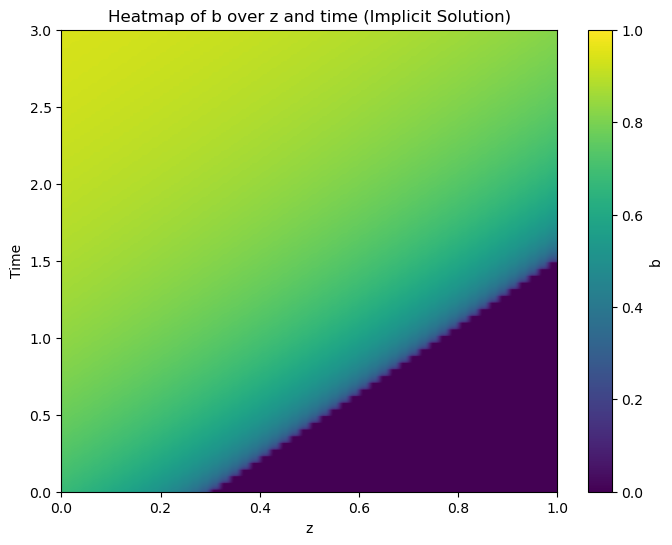

In [21]:
z_targets = np.linspace(0,1, 50)
b_results = np.zeros((len(t_values), len(z_targets)))

for t in range(len(t_values)):
    for zt in range(len(z_targets)):
        # Find index of closest z value in z_values[t]
        z_index = np.abs(z_values[t] - z_targets[zt]).argmin()

        b_results[t, zt] = b_values[z_index]

# Plot the b results as a heatmap with the x-axis being z and the y-axis being time
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(
    b_results,
    aspect='auto',
    cmap='viridis',
    origin='lower',
    extent=(z_targets[0], z_targets[-1], 
            t_values[0], t_values[-1]),
    vmin=0, vmax=1  # Set the colour scale for b values
)
ax.set_title('Heatmap of b over z and time (Implicit Solution)')
ax.set_xlabel('z')
ax.set_ylabel('Time')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('b')
plt.show()

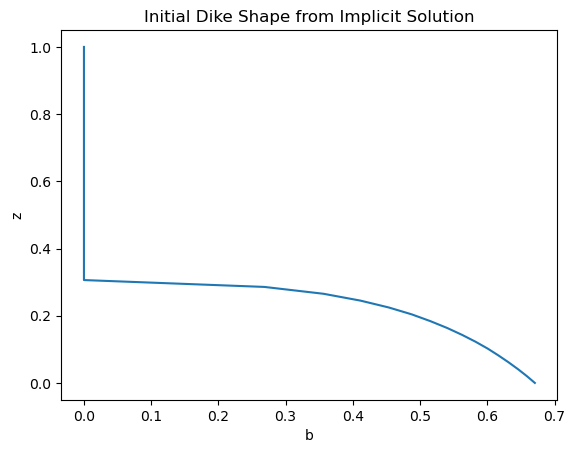

In [22]:
# Extract b values at t = 0 and plot
b_t0 = b_results[0, :]
plt.plot(b_t0, z_targets)
plt.xlabel('b')
plt.ylabel('z')
plt.title('Initial Dike Shape from Implicit Solution')
plt.show()